In [1]:
import keras
import keras.backend as K
from keras import models, layers

Using TensorFlow backend.


In [2]:
from keras.layers import Input, AveragePooling2D, Conv2D, Flatten, Layer
from keras.models import Model
from keras.applications import vgg19

In [3]:
import numpy as np
from PIL import Image

In [4]:
IMAGENET_MEANS = np.array([103.939, 116.779, 123.68])

In [5]:
def content_loss(content, combination):
    return 0.5 * K.sum(K.square(combination - content))

In [6]:
def gram(x):
    shape = K.shape(x)
    F = K.reshape(x, (shape[0] * shape[1], shape[2]))
    return K.dot(K.transpose(F), F)

In [7]:
def style_loss(style, combination):
    Ml2 = int(style.shape[0] * style.shape[1])**2
    N12 = int(style.shape[2])**2
    return K.sum(K.square(gram(style) - gram(combination))) / (4. * N12 * Ml2)

In [8]:
def total_variation_loss(x, kind='isotropic'):
    h, w = x.shape[1], x.shape[2]
    if kind == 'anisotropic':
        a = K.abs(x[:, :h-1, :w-1, :] - x[:, 1:, :w-1, :])
        b = K.abs(x[:, :h-1, :w-1, :] - x[:, :h-1, 1:, :])
        return K.sum(a + b)
    elif kind == 'isotropic':
        a = K.square(x[:, :h-1, :w-1, :] - x[:, 1:, :w-1, :])
        b = K.square(x[:, :h-1, :w-1, :] - x[:, :h-1, 1:, :])
        return K.sum(K.pow(a + b, 2))
    else:
        raise ValueError("`kind` should be 'anisotropic' or 'isotropic'")

In [115]:
def load_image(image_path, size=None):
    image = Image.open(image_path)
    if size is not None:
        image = image.resize(size)
    return image

def image_to_matrix(image, dtype=np.float32):
    image = np.asarray(image, dtype=dtype)
    image = np.expand_dims(image, axis=0)
    return image

def matrix_to_image(image, channel_range=(0, 255)):
    image = np.clip(image, *channel_range).astype('uint8')
    return Image.fromarray(image)

def normalize(image, inplace=False):
    assert image.shape[3] == IMAGENET_MEANS.shape[0]
    if not inplace:
        image = image.copy()
    image = image[:, :, :, ::-1]
    image[:, :, :, np.arange(IMAGENET_MEANS.shape[0])] -= IMAGENET_MEANS
    return image

def denormalize(image, inplace=False):
    assert image.shape[2] == IMAGENET_MEANS.shape[0]
    if not inplace:
        image = image.copy()
    image[:, :, np.arange(IMAGENET_MEANS.shape[0])] += IMAGENET_MEANS
    image = image[:, :, ::-1]
    return image

def load_content_style(content_path, style_path):
    content = load_image(content_path)
    image_size = content.size
    style = load_image(style_path, image_size)
    content = image_to_matrix(content)
    style = image_to_matrix(style)
    content = normalize(content)
    style = normalize(style)
    return content, style

In [99]:
def load_model(input_tensor, weights_path):
    input_tensor = Input(tensor=input_tensor, shape=(None, None, 3))
    Pool2D = AveragePooling2D
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_tensor)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = Pool2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = Pool2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = Pool2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = Pool2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
    x = Pool2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    model = Model(input_tensor, x)
    model.load_weights(weights_path)
    
    #model = vgg19.VGG19(include_top=False, input_tensor=tensor, pooling='avg')

    return model

In [173]:
content_path = './img/golden_gate.jpg'
style_path = './img/the-starry-night.jpg'
weights_path = './models/vgg19_for_style_weights.h5'

In [174]:
content, style = load_content_style(content_path, style_path)
content_tensor = K.constant(content, name='Content')
style_tensor = K.constant(style, name='Style')
canvas = K.placeholder(content.shape, name='Canvas')
tensor = K.concatenate([content_tensor, style_tensor, canvas], axis=0)
model = load_model(tensor, weights_path)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1']
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

In [175]:
loss = K.variable(0.0, name='Loss')
layer_features = outputs_dict[content_layer]
content_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(content_features, combination_features)

for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl

loss += total_variation_weight * total_variation_loss(canvas)

grads = K.gradients(loss, canvas)[0]
fetch_loss_and_grads = K.function([canvas], [loss, grads])

In [176]:
#initial = np.random.uniform(0, 1, size=canvas.shape)
initial = content.copy()
#initial = style.copy()

learning_rate = 1e-2
loss_history = []
iterations = 30

In [ ]:
# adam
X = initial
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
moment1 = np.zeros_like(X)
moment2 = np.zeros_like(X)
for i in range(iterations):
    loss_i, grads_i = fetch_loss_and_grads([X])
    moment1 = beta1 * moment1 + (1 - beta1) * grads_i
    moment2 = beta2 * moment2 + (1 - beta1) * grads_i**2
    debias1 = moment1 / (1 - beta1**(i+1))
    debias2 = moment2 / (1 - beta2**(i+1))
    X -= learning_rate * debias1 / (debias2**0.5 + epsilon)
    loss_history.append(loss_i)
    print(i, loss_i)
image = X

0 745138560.0
1 745051600.0
2 744965100.0
3 744878660.0
4 744792600.0
5 744706200.0
6 744619900.0
7 744533600.0
8 744447000.0
9 744361000.0
10 744274750.0
11 744188540.0
12 744102300.0
13 744015740.0
14 743929500.0
15 743843300.0
16 743756800.0


In [167]:
# gradient descent
X = initial
for i in range(iterations):
    loss_i, grads_i = fetch_loss_and_grads([X])
    X -= learning_rate * grads_i
    loss_history.append(loss_i)
    print(i, loss_i)
image = X

0 745138560.0
1 467461950.0
2 377612640.0
3 325262900.0
4 290262530.0
5 264799740.0
6 245168380.0
7 229412340.0
8 216375740.0
9 205327260.0
10 195798820.0
11 187451070.0
12 180045280.0
13 173411000.0
14 167418860.0
15 161969630.0
16 156983730.0
17 152395820.0
18 148153440.0
19 144217460.0
20 140554500.0
21 137135580.0
22 133937520.0
23 130936510.0
24 128112560.0
25 125448880.0
26 122929540.0
27 120544480.0
28 118281270.0
29 116131020.0
30 114084856.0
31 112134750.0
32 110274424.0
33 108496930.0
34 106796420.0
35 105167160.0
36 103604700.0
37 102105040.0
38 100664430.0
39 99279010.0
40 97946020.0
41 96662270.0
42 95424910.0
43 94230920.0
44 93079020.0
45 91966700.0
46 90891410.0
47 89850960.0
48 88843470.0
49 87867680.0


In [168]:
K.clear_session()

In [169]:
image = image.reshape(canvas.shape)[0]
image = denormalize(image)
image = matrix_to_image(image)

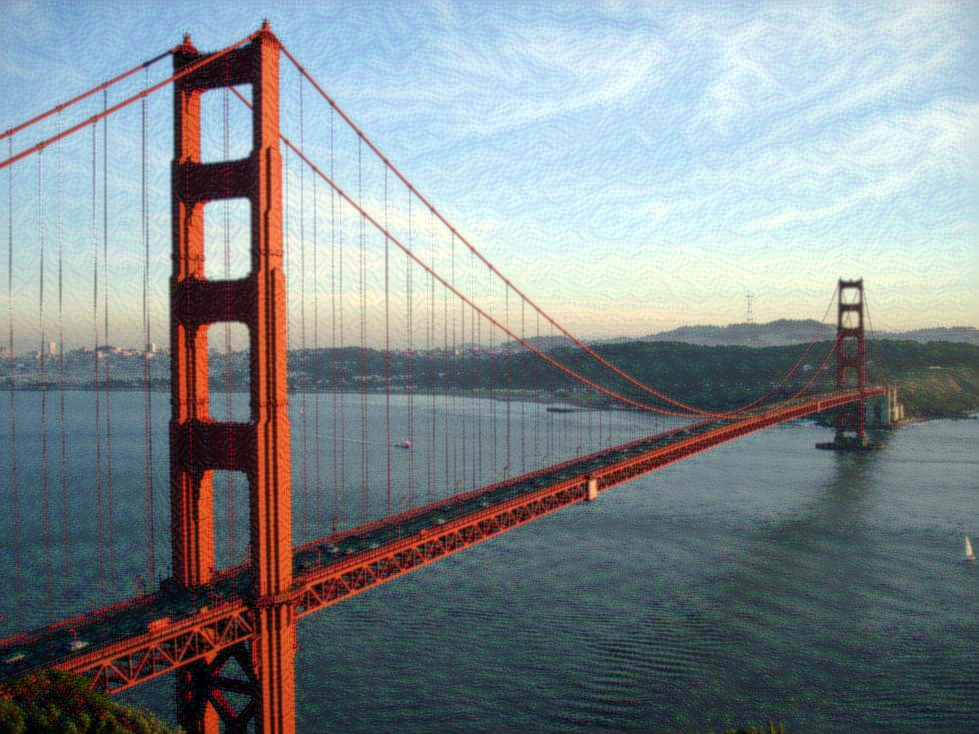

In [170]:
image

In [ ]:
model.save('./models/vgg19_for_style.h5')

In [32]:
vgg = vgg19.VGG19(include_top=False, input_tensor=tensor, pooling='avg')

In [33]:
vgg.save_weights('./models/vgg19_for_style_weights.h5')